### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Found path: /data/Reacher_Linux_NoVis/Reacher.x86_64
Mono path[0] = '/data/Reacher_Linux_NoVis/Reacher_Data/Managed'
Mono config path = '/data/Reacher_Linux_NoVis/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
PlayerPrefs - Creating folder: /home/student/.config/unity3d/Unity Technologies
PlayerPrefs - Creating folder: /home/student/.config/unity3d/Unity Technologies/Unity Environment
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [4]:
!pip install torch==2.0.1 --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
import torch
import numpy as np
import copy
import random
from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

In [7]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, shape, seed, mu=0., theta=0.15, sigma=0.08):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(shape)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * (np.random.rand(*x.shape)-0.5)
        self.state = x + dx
        return self.state

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1=128, fc2=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, action_size)
        
        #batchnorm
        self.bn_input = nn.BatchNorm1d(fc1)
        self.bn_hidden = nn.BatchNorm1d(fc1)

        #Dropout
        self.dpout = nn.Dropout(p=0.20)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = self.fc1(state) 
        x = self.bn_input(x)
        x = F.relu(x)

        #First hidden layer: Dense + ReLU
        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        out = torch.tanh(x)
        return out

    
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1=128, fc2=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fcs1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1 + action_size, fc2) #concat the action from the actor
        self.fc3 = nn.Linear(fc2, 1)
        
        #batchnorm
        self.bn_input = nn.BatchNorm1d(fc1)
        
        #Dropout
        self.dpout = nn.Dropout(p=0.20)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

        x = self.fcs1(state) 
        x = self.bn_input(x)
        x = F.relu(x)

        #First hidden layer Dense + ReLU
        #Concat state & action
        x = torch.cat((x, action), dim=1)
        x = self.fc2(x)
        x = F.relu(x)

        #Output layer: Dense
        out = self.fc3(x)
        return out

In [10]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.95            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
TRAIN_EVERY = 20        # How many iterations to wait before updating target networks
NUM_AGENTS = 20         # How many agents are there in the environment
SEED=12345

In [11]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR) #, weight_decay=WEIGHT_DECAY)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        #Copy the weights from local to target networks
        self.soft_update(self.critic_local, self.critic_target, 1)
        self.soft_update(self.actor_local, self.actor_target, 1)
        
        # Noise process
        self.noise = OUNoise((NUM_AGENTS, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done, step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > BATCH_SIZE and (step % TRAIN_EVERY) == 0 :
            for _ in range(7) :
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""

        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()
        
        if add_noise:
            action += self.noise.sample()
        
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
                
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        # Get action from actor's network, given the NEXT state        
        actions_next = self.actor_target(next_states)
        # Use the obtained action as input to the critic's network, along with the NEXT state
        Q_targets_next = self.critic_target(next_states, actions_next).detach()
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        #Get the expected value from the critic's local network
        Q_expected = self.critic_local(states, actions)
        
        # Compute critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        #Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)

        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        #Get the "best" action using the actor's local network, given current state
        actions_pred = self.actor_local(states)
        
        #Compute the loss by getting the expected value (V) from the critic's local network,
        #given the current state and the obtained action. 
        #Set it negative to perform gradient ascent?
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [12]:

agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED)

### DDPG Implementation ###
# This is the implementation for DDPG Algorithm

def ddpg(n_episodes=1000, max_t=1000, print_every=5):
    scores = []
    scores_deque = deque(maxlen=print_every)                  # A queue to keep only the last 100 episodes' scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    

        states = env_info.vector_observations                 # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        
        agent.reset()                                         # Reset the agent to start the episode
        for t in range(max_t):                                # A loop for the iterations
            actions = agent.act(states)                       # Get an action from the Actor's network, given the current state
            env_info = env.step(actions)[brain_name]          # send all actions to the environment
            next_states = env_info.vector_observations        # get next state (for each agent)
            rewards = env_info.rewards                        # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished
            score += env_info.rewards                         # update the score (for each agent)
            
            for i in range(20) :
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], t)
            
            states = next_states                              # Roll over states to next time step

            if np.any(dones):                                 # exit loop if episode finished
                break
                
        score = score.mean()                                  # Get the mean score of the episode (over all agents)
        scores_deque.append(score)                            # Store the score in the queue
        scores.append(score)                                  # Store the score in the list (for plotting)
        
        # Print out the mean score per episode
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")

        mean_sc = np.mean(scores_deque)                       # Compute the mean score over the last 100 episodes
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_sc))
            
        if mean_sc >= 30 :
            print('\rEnvironment solved in {} episodes, mean score: {:.2f}'.format(i_episode, mean_sc))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

In [13]:
scores = ddpg()

Episode 5	Average Score: 0.96
Episode 10	Average Score: 2.51
Episode 15	Average Score: 3.92
Episode 20	Average Score: 6.72
Episode 25	Average Score: 11.26
Episode 30	Average Score: 18.79
Episode 35	Average Score: 21.05
Episode 40	Average Score: 25.10
Environment solved in 44 episodes, mean score: 31.46


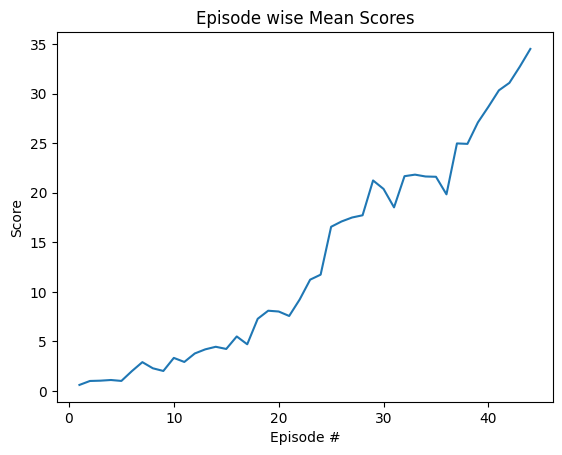

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Episode wise Mean Scores')
plt.show()